# Interactive Colormap Example: Salinity Data

This notebook demonstrates how to use the interactive colormap widget to create optimal nonlinear colormaps for oceanographic data, using **salinity** as the primary example.

Salinity is an ideal test case because the data is highly concentrated within a narrow range (35.04-35.09 g/kg) with sparse values at the extremes - perfect for demonstrating the power of nonlinear colorbar normalization.

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Import the interactive colormap widget
from oceanvis_py.plots.widgets import create_colormap_widget

In [2]:
# Load example oceanographic data (towyo section)
data_path = Path("../data/m212_072_towyo_interpolated.nc")

if data_path.exists():
    ds = xr.open_dataset(data_path)
    print("Dataset loaded successfully!")
    print(f"Variables: {list(ds.data_vars.keys())}")
    print(f"SA (salinity) range: {ds.SA.min().values:.3f} to {ds.SA.max().values:.3f} g/kg")
else:
    print("Data file not found. Creating synthetic salinity data for demonstration.")

    # Create synthetic salinity data with realistic distribution
    np.random.seed(42)
    distance = np.linspace(0, 100, 80)
    pressure = np.linspace(50, 1000, 60)
    D, P = np.meshgrid(distance, pressure)

    # Realistic salinity: concentrated around 35.0 with some spatial variation
    base_salinity = 35.05
    depth_gradient = -0.02 * (P - 200) / 800  # Slight increase with depth
    spatial_variation = 0.01 * np.sin(2 * np.pi * D / 50)  # Spatial waves
    noise = np.random.normal(0, 0.003, D.shape)  # Small-scale noise

    SA_data = base_salinity + depth_gradient + spatial_variation + noise

    # Create dataset
    ds = xr.Dataset({
        'SA': (('pressure', 'distance'), SA_data)
    }, coords={
        'pressure': pressure,
        'distance': distance
    })

    print(f"Created synthetic salinity data")
    print(f"SA range: {ds.SA.min().values:.3f} to {ds.SA.max().values:.3f} g/kg")

Dataset loaded successfully!
Variables: ['CT', 'SA', 'sigma2', 'temperature', 'salinity', 'conductivity', 'latitude', 'longitude', 'waterdepth', 'u_velocity', 'v_velocity']
SA (salinity) range: 35.040 to 35.086 g/kg


/home/runner/micromamba/envs/oceanvis-py/lib/python3.14/site-packages/xarray/backends/plugins.py:109: RuntimeWarning: Engine 'gmt' loading failed:
Error loading GMT shared library at 'libgmt.so'.
libgmt.so: cannot open shared object file: No such file or directory
  external_backend_entrypoints = backends_dict_from_pkg(entrypoints_unique)


## Understanding Salinity Distribution

Let's examine why salinity data benefits from nonlinear colormaps:

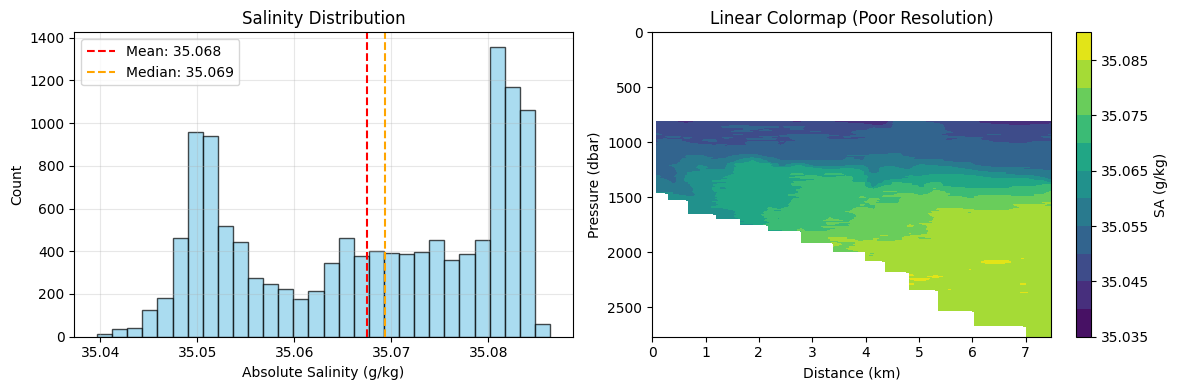

Key insight: Most data is concentrated in narrow range!
90% of data lies between: 35.049 and 35.084
But full range is: 35.040 to 35.086

→ Linear colormaps waste color resolution on sparse extremes


In [3]:
# Analyze salinity distribution
sa_data = ds.SA.values.flatten()
sa_clean = sa_data[~np.isnan(sa_data)]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Histogram
ax1.hist(sa_clean, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
ax1.axvline(sa_clean.mean(), color='red', linestyle='--',
           label=f'Mean: {sa_clean.mean():.3f}')
ax1.axvline(np.median(sa_clean), color='orange', linestyle='--',
           label=f'Median: {np.median(sa_clean):.3f}')
ax1.set_xlabel('Absolute Salinity (g/kg)')
ax1.set_ylabel('Count')
ax1.set_title('Salinity Distribution')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Simple section plot with linear colormap (problematic)
im = ax2.contourf(ds.distance, ds.pressure, ds.SA, levels=10, cmap='viridis')
ax2.set_xlabel('Distance (km)')
ax2.set_ylabel('Pressure (dbar)')
ax2.set_title('Linear Colormap (Poor Resolution)')
ax2.invert_yaxis()
plt.colorbar(im, ax=ax2, label='SA (g/kg)')

plt.tight_layout()
plt.show()

print(f"Key insight: Most data is concentrated in narrow range!")
print(f"90% of data lies between: {np.percentile(sa_clean, 5):.3f} and {np.percentile(sa_clean, 95):.3f}")
print(f"But full range is: {sa_clean.min():.3f} to {sa_clean.max():.3f}")
print(f"\n→ Linear colormaps waste color resolution on sparse extremes")

## Interactive Colormap Explorer

Use the widget below to explore different colormap strategies for salinity data.

**Try these settings:**
1. **Linear** method → Notice poor resolution in main data range
2. **Percentile** method → Much better!
3. **Compressed Percentile** → Optimal for concentrated distributions
4. Experiment with **10-20 levels** for discrete colormaps
5. Try the **SAL** colormap (blue to pale yellow, designed for salinity)

**Key features to explore:**
- **Method**: Linear vs Percentile vs Compressed Percentile
- **Number of levels**: More levels = smoother gradients
- **Colormap**: SAL (salinity-specific) vs other scientific colormaps

In [4]:
# Create interactive widget for salinity
salinity_widget = create_colormap_widget(ds.SA, 'Absolute Salinity (g/kg)')

# Set default to SAL colormap if available
try:
    salinity_widget.colormap_dropdown.value = 'SAL'
    print("Using custom SAL colormap (blue to pale yellow for salinity)")
except (ValueError, AttributeError):
    print("Using default colormap")

# Display the widget
salinity_widget.display()

Using custom SAL colormap (blue to pale yellow for salinity)


## Applying Your Settings to Section Plots

Once you've found optimal settings above:
1. Click the **"Generate Code"** button to get copy-paste code
2. Use the generated code in your section plots

Here's an example of how to apply the results:

Example: Creating optimized salinity section plot
Optimized levels: [35.04  35.043 35.046 35.049 35.052 35.055 35.058 35.061 35.065 35.068
 35.071 35.074 35.077 35.08  35.083 35.086]
Level spacing varies to match data density!
Using custom SAL colormap


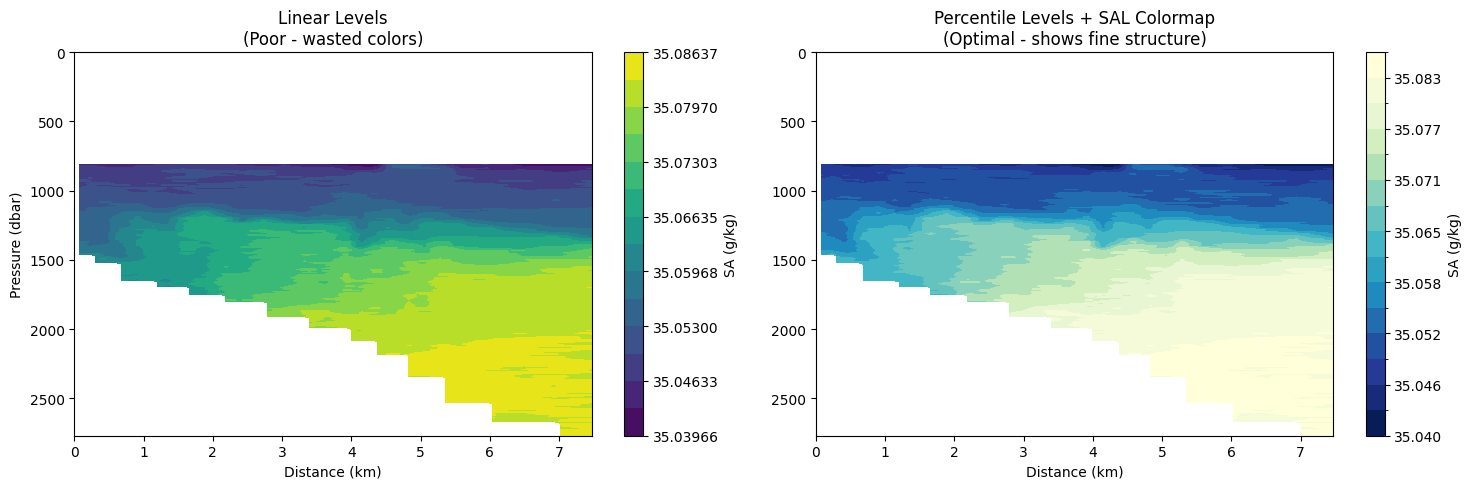


✓ The optimized version reveals fine-scale salinity structure!
✓ Use the widget above to experiment with different approaches


In [5]:
# Example: Apply optimized colormap to section plot
from oceanvis_py.plots.widgets import calculate_histogram_levels
from matplotlib.colors import ListedColormap, BoundaryNorm

print("Example: Creating optimized salinity section plot")

# Calculate optimal levels using percentile method (15 levels)
sa_clean = ds.SA.values[~np.isnan(ds.SA.values)]
sa_levels = calculate_histogram_levels(sa_clean, n_levels=15, method='percentile')

print(f"Optimized levels: {sa_levels}")
print(f"Level spacing varies to match data density!")

# Create discrete colormap
try:
    from oceanvis_py.core.custom_colormaps import CUSTOM_COLORMAPS
    sal_cmap = ListedColormap(CUSTOM_COLORMAPS['SAL'](np.linspace(0, 1, 15)))
    print("Using custom SAL colormap")
except ImportError:
    sal_cmap = ListedColormap(plt.cm.Blues(np.linspace(0, 1, 15)))
    print("Using fallback Blues colormap")

sal_norm = BoundaryNorm(sa_levels, 15)

# Create optimized plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Linear colormap (poor)
im1 = ax1.contourf(ds.distance, ds.pressure, ds.SA,
                   levels=np.linspace(ds.SA.min().values, ds.SA.max().values, 15),
                   cmap='viridis')
ax1.set_title('Linear Levels\n(Poor - wasted colors)')
ax1.set_xlabel('Distance (km)')
ax1.set_ylabel('Pressure (dbar)')
ax1.invert_yaxis()
plt.colorbar(im1, ax=ax1, label='SA (g/kg)')

# Optimized colormap (good)
im2 = ax2.contourf(ds.distance, ds.pressure, ds.SA,
                   levels=sa_levels,
                   cmap=sal_cmap, norm=sal_norm)
ax2.set_title('Percentile Levels + SAL Colormap\n(Optimal - shows fine structure)')
ax2.set_xlabel('Distance (km)')
ax2.invert_yaxis()
plt.colorbar(im2, ax=ax2, label='SA (g/kg)')

plt.tight_layout()
plt.show()

print("\n✓ The optimized version reveals fine-scale salinity structure!")
print("✓ Use the widget above to experiment with different approaches")

## Summary

**Key takeaways for salinity visualization:**

1. **Salinity data is concentrated** → Linear colormaps waste color resolution
2. **Percentile-based levels** → Much better for revealing fine structure
3. **Custom SAL colormap** → Designed specifically for salinity (blue to pale yellow)
4. **Interactive widgets** → Fast way to find optimal settings
5. **Generate code** → Easy to apply settings to your own plots

**Next steps:**
- Try the widget with your own oceanographic data
- Experiment with temperature (broader distribution)
- Use symmetric colormaps for velocity data
- Save your favorite settings as CPT files